In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from skimage.metrics import structural_similarity as ssim
from methods import RMSELoss, TikhonovTomography, GCVloss

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0 
plt.rcParams['ytick.major.width'] = 1.0 
plt.rcParams['font.size'] = 9  
plt.rcParams['axes.linewidth'] = 1.0 

torch.manual_seed(5)
np.random.seed(5)
random.seed(5)
D_DIM = 12  # detector dimensition
F_DIM = 64  # reconstructed image dimenstion
NOISE_RATE = 0.125 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# d = Rf
R = np.load(f"R_{D_DIM}_{F_DIM}.npy")
f = np.load(f"f_{F_DIM}.npy")[:, ::-1]
d = R.dot(f.flatten())
ls_image = np.load(f"ls_image_{F_DIM}.npy")
model = TikhonovTomography(R=R, d=d, ls_img=ls_image, device=device, noise_rate=NOISE_RATE)
train_y_img = torch.tensor(f.flatten())
train_y = model.d.detach().to(device)

model = model.to(device, dtype=torch.float32)
train_y_img = train_y_img.to(device, dtype=torch.float32)

loss_function2 = RMSELoss()
loss_function = GCVloss()

In [3]:
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.1)

model.train()
training_iter = 100
prev_loss = torch.tensor(20000.0).to(device)

for i in range(training_iter):
    optimizer.zero_grad()
    f_out, d_out, omega_sum = model()
    loss = loss_function(d_out, train_y, omega_sum)
    loss_img = loss_function2(f_out, train_y_img)
    if prev_loss > loss:
        prev_loss = loss
        prev_loss_img = loss_img
        prev_f = f_out
        for n, p in model.named_parameters():
            print(n, p)
    loss.backward(retain_graph=True)
    optimizer.step()

for n, p in model.named_parameters():
    print(n, p)

alpha Parameter containing:
tensor(1., device='cuda:0', requires_grad=True)
alpha Parameter containing:
tensor(0.9000, device='cuda:0', requires_grad=True)
alpha Parameter containing:
tensor(0.8001, device='cuda:0', requires_grad=True)
alpha Parameter containing:
tensor(0.7005, device='cuda:0', requires_grad=True)
alpha Parameter containing:
tensor(0.6013, device='cuda:0', requires_grad=True)
alpha Parameter containing:
tensor(0.5027, device='cuda:0', requires_grad=True)
alpha Parameter containing:
tensor(0.4051, device='cuda:0', requires_grad=True)
alpha Parameter containing:
tensor(0.3091, device='cuda:0', requires_grad=True)
alpha Parameter containing:
tensor(0.2153, device='cuda:0', requires_grad=True)
alpha Parameter containing:
tensor(0.1249, device='cuda:0', requires_grad=True)
alpha Parameter containing:
tensor(0.0394, device='cuda:0', requires_grad=True)
alpha Parameter containing:
tensor(-0.0250, device='cuda:0', requires_grad=True)
alpha Parameter containing:
tensor(0.0113, 

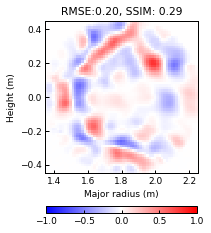

In [4]:
out_f = prev_f.detach().cpu().numpy().reshape(*f.shape)
rmse_loss = prev_loss_img.detach().cpu().numpy()
ssim_loss = ssim(out_f, f,
                 data_range=f.max() - f.min())
plt.axes().set_aspect('equal')
plt.title(f"RMSE:{rmse_loss:.2f}, SSIM: {ssim_loss:.2f}")
y = np.linspace(-0.45, 0.45, F_DIM)
x = np.linspace(1.35, 2.25, F_DIM)
X, Y = np.meshgrid(x, y)
plt.ylabel("Height (m)")
plt.xlabel("Major radius (m)")
plt.pcolor(X, Y, out_f, cmap="bwr", vmax=1., vmin=-1.)
plt.colorbar(orientation="horizontal", shrink=0.45)
# plt.savefig(f"L2_{D_DIM}_{NOISE_RATE:.2f}.png")